In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Fdisk Gadget

In [5]:
import matplotlib.pyplot as plt
import h5py
import numpy as np
import time_conversion as tiempo
import density
import rotation_mio as rot

h=0.732
G = 4.299e-6
a0=1
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter
vector2 = ('M31','MW','M33')
vector = ('00','01','03')

path = '/home/ornela/SimCLUES/'
# path = '/home/omarioni/'

atime = np.loadtxt(path + 'redshift_outputs.txt')
aexp = atime[:,2]
# aexp = aexp[::-1]

# path = '/mnt/is2/alejandro/ornella/'
##hasta 50

snapshot=range(496,50,-1)
for isnap in snapshot:
    snap = h5py.File(path + 'outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')
    
#     print aexp[isnap]

#     lala

    for i in range(0,3):
        cm   = snap['subhalo_0'+ str('%s'%vector[i])+ '/Center'].value
        r200 = snap['subhalo_0'+ str('%s'%vector[i])+ '/R200'].value

        pstr = snap['subhalo_0'+ str('%s'%vector[i])+ '/Str/Coordinates'].value
        mstr = snap['subhalo_0'+ str('%s'%vector[i])+ '/Str/Masses'].value
        vel  = snap['subhalo_0'+ str('%s'%vector[i])+ '/Str/Velocities'].value
        
        pgas = snap['subhalo_0'+ str('%s'%vector[i])+ '/Gas/Coordinates'].value
        mgas = snap['subhalo_0'+ str('%s'%vector[i])+ '/Gas/Masses'].value
        
        pdrk = snap['subhalo_0'+ str('%s'%vector[i])+ '/Drk/Coordinates'].value
        mdrk = snap['subhalo_0'+ str('%s'%vector[i])+ '/Drk/Masses'].value

        z = a0/aexp[isnap] - 1.
        Ht = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
        time = tiempo.conv(z, h, omega_lambda, omega_matter)

    #---aca paso las coordenadas respecto al centro de la galaxia------
        xstr = (pstr[:,0]-cm[0])*aexp[isnap]/h
        ystr = (pstr[:,1]-cm[1])*aexp[isnap]/h
        zstr = (pstr[:,2]-cm[2])*aexp[isnap]/h
        rstr = np.sqrt(xstr**2+ystr**2+zstr**2)
        
        xgas = (pgas[:,0]-cm[0])*aexp[isnap]/h
        ygas = (pgas[:,1]-cm[1])*aexp[isnap]/h
        zgas = (pgas[:,2]-cm[2])*aexp[isnap]/h
        rgas = np.sqrt(xgas**2+ygas**2+zgas**2)
        
        xdrk = (pdrk[:,0]-cm[0])*aexp[isnap]/h
        ydrk = (pdrk[:,1]-cm[1])*aexp[isnap]/h
        zdrk = (pdrk[:,2]-cm[2])*aexp[isnap]/h
        rdrk = np.sqrt(xdrk**2+ydrk**2+zdrk**2)
         
        v_x = vel[:,0] *np.sqrt(aexp[isnap]) + Ht *xstr/1000.
        v_y = vel[:,1] *np.sqrt(aexp[isnap]) + Ht *ystr/1000.
        v_z = vel[:,2] *np.sqrt(aexp[isnap]) + Ht *zstr/1000.
        
#----------------------masas----------------------------
        mstr = mstr*1e10/h
        mgas = mgas*1e10/h
        mdrk = mdrk*1e10/h
        
        r200 = r200*aexp[isnap]/h
        
#         print 'r200 =', r200
        rgal=0.15*r200
        
        limit    = np.where(rstr<rgal)
        r_sort   = np.sort(rstr[limit])
        r_indice = np.argsort(rstr[limit])
        
        Mgal_str = np.cumsum((mstr[limit])[r_indice])
        M_gal = Mgal_str[-1]
    

    #------------------ calculamos M90------------------------------------------
        razon  = Mgal_str/M_gal
        cincuenta,    = np.where(razon < 0.50)

        r50 = r_sort[cincuenta][-1]
        M50 = Mgal_str[cincuenta][-1]

        #componentes de la velocidad del centro de masa
        veloc, = np.where(rstr < r50)

        vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
        vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
        vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

        #velocidades de las estrellas respecto del centro de masa de la galaxia
        vx = v_x - vxcm
        vy = v_y - vycm
        vz = v_z - vzcm

        #-------------------------------------------------------------------------------------
        #hago la rotación de las coordenadas respecto del momento angular    
        e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp[isnap])

        xn = e1x*xstr + e1y*ystr + e1z*zstr
        yn = e2x*xstr + e2y*ystr + e2z*zstr
        zn = e3x*xstr + e3y*ystr + e3z*zstr
        vxn = e1x*vx + e1y*vy + e1z*vz
        vyn = e2x*vx + e2y*vy + e2z*vz
        vzn = e3x*vx + e3y*vy + e3z*vz

        rn = np.sqrt(xn**2 + yn**2 + zn**2 )

        limit, = np.where(rn < rgal )

        R = np.sqrt(xn[limit]**2+yn[limit]**2)

        nbin = 25
        den, Rbin = density.surf_density(R,mstr[limit],nbin)
        
        
        cut, = np.where(Rbin > 3*aexp[isnap])
        pol  = np.polyfit(Rbin[cut],np.log(den[cut]),1)

        Rd = -1./pol[0]

        Md = 2*np.pi*np.exp(pol[1])*Rd**2

    #--------------------------------------------         
        rtot = np.concatenate([rstr, rgas, rdrk])
        mtot = np.concatenate([mstr, mgas, mdrk])
        
        limit_tot   = np.where(rtot<r200)
        rtot_sort   = np.sort(rtot[limit_tot])
        rtot_indice = np.argsort(rtot[limit_tot])
        
        Mc_tot = np.cumsum((mtot[limit_tot])[rtot_indice])
        
#-------------------------------------------------------------- 
        Mtot_50 = Mc_tot[np.where(rtot_sort < r50)][-1]

        Vr50 = np.sqrt((G*Mtot_50)/r50)
        
        fdisk = Vr50 / np.sqrt((G*M_gal)/r50)
                            

        Vtot = np.sqrt((G*Mc_tot)/rtot_sort)
    
        Vmax = np.max(Vtot)
        rmax = rtot_sort[np.argmax(Vtot)]
        
#         fdisk0 = Vmax / np.sqrt((G*M_gal*1e10)/r50)
#         fdisk1 = Vmax / np.sqrt((G*Md)/Rd)

#         print fdisk1
#         print Vmax
#         print fdisk
        
#--------------------------------------------------------------------------------------------------------------------

#         archivo1 =  open('/home/omarioni/Barras_GdGs/Barras_Gd/_data/'+str('%s'%vector2[i])+'_fdisk_time.dat','a')
#         archivo1.write(str('%12.6f'% time) +'\t'+
#                        str('%12.6f'% fdisk) +'\t'+
#                        str('%12.6f'% r50) +'\t'+
#                        str('%12.6f'% (M_gal*1e10)) +'\t'+
#                        str('%12.6f'% (M50*1e10)) +'\t'+
#                        str('%12.6f'% (Mgas_50*1e10)) +'\t'+
#                        str('%12.6f'% (Mdrk_50*1e10)) +'\t'+
#                        str('%12.6f'% Vr50) +'\n')
#         archivo1.close()   
        path3 = '/home/ornela/PYTHON/Barras_GdGs/Barras_Gd/_data/correcciones/'
#         archivo =  open('/home/omarioni/Barras_GdGs/Barras_Gd/_data/correcciones'+str('%s'%vector2[i])+'_param4fdisk_GD.dat','a')
        archivo =  open(path3 + str('%s'%vector2[i]) + '_param4fdisk_GD.dat','a')
        archivo.write(str('%12.6f'% time) +'\t'+
                      str('%12.6f'% r50) +'\t'+
                      str('%12.6f'% rmax) +'\t'+
                      str('%12.6f'% Rd) +'\t'+
                      str('%12.6f'% rgal) +'\t'+
                      str('%12.6f'% M_gal) +'\t'+
                      str('%12.6f'% Md) +'\t'+
                      str('%12.6f'% Vmax) +'\t'+
                      str('%12.6f'% Vr50) +'\n')
        archivo.close()

/home/ornela/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:157: RuntimeWarning: divide by zero encountered in divide


## Fdisk Gasoline

In [42]:
import matplotlib.pyplot as plt
import h5py
import rotation as rot
import numpy as np


G = 4.299e-6
a0=1
vector2 = ('M31','MW','M33')
vector = (1,2,4)

path = '/home/ornela/SimCLUES/'
# path = '/mnt/sersic2/omarioni/'

snapshot = np.loadtxt(path + 'Gasoline/snapshots.txt', dtype='string')


for j in range(len(snapshot)-1,0,-1):
    snap = h5py.File(path + 'Gasoline/outputs2/snap_'+str('%s'%snapshot[j])+'.h5py', 'r')

    for i in range(0,3):
        cm   = snap['subhalo_00'+ str('%s' %vector[i])+ '/Center'][()]
        r200 = snap['subhalo_00'+ str('%s' %vector[i])+ '/R200'][()]
        time = snap['subhalo_00'+ str('%s' %vector[i])+ '/Time'][()]
        h    = snap['subhalo_00'+ str('%s' %vector[i])+ '/h'][()]
        aexp = snap['subhalo_00'+ str('%s' %vector[i])+ '/aexp'][()]

        pstr = snap['subhalo_00'+ str('%s'%vector[i]) + '/Str/Coordinates'][()]
        mstr = snap['subhalo_00'+ str('%s' %vector[i])+ '/Str/Masses'][()]
        vel  = snap['subhalo_00'+ str('%s' %vector[i])+ '/Str/Velocities'][()]

        pgas = snap['subhalo_00'+ str('%s' %vector[i])+ '/Gas/Coordinates'][()]
        mgas = snap['subhalo_00'+ str('%s' %vector[i])+ '/Gas/Masses'][()]

        pdrk = snap['subhalo_00'+ str('%s' %vector[i])+ '/Drk/Coordinates'][()]
        mdrk = snap['subhalo_00'+ str('%s' %vector[i])+ '/Drk/Masses'][()]


    #---aca paso las coordenadas respecto al centro de la galaxia------
        xstr = (pstr[:,0]-cm[0]) #*aexp
        ystr = (pstr[:,1]-cm[1])
        zstr = (pstr[:,2]-cm[2])
        rstr = np.sqrt(xstr**2+ystr**2+zstr**2)

        xgas = (pgas[:,0]-cm[0])
        ygas = (pgas[:,1]-cm[1])
        zgas = (pgas[:,2]-cm[2])
        rgas = np.sqrt(xgas**2+ygas**2+zgas**2)

        xdrk = (pdrk[:,0]-cm[0])
        ydrk = (pdrk[:,1]-cm[1])
        zdrk = (pdrk[:,2]-cm[2])
        rdrk = np.sqrt(xdrk**2+ydrk**2+zdrk**2)

        v_x = vel[:,0]
        v_y = vel[:,1]
        v_z = vel[:,2]

    #----------------------masas----------------------------
        r200 = r200*aexp
        rgal=0.15*r200

        limit    = np.where(rstr<rgal)
        r_sort   = np.sort(rstr[limit])
        r_indice = np.argsort(rstr[limit])
        
        Mgal_str = np.cumsum((mstr[limit])[r_indice])
        M_gal = Mgal_str[-1]
        
    #------------------ calculamos M90------------------------------------------
        razon  = Mgal_str/M_gal
        cincuenta,    = np.where(razon < 0.50)

        r50 = r_sort[cincuenta][-1]
        M50 = Mgal_str[cincuenta][-1]

        #componentes de la velocidad del centro de masa
        veloc, = np.where(rstr < r50)

        vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
        vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
        vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

        #velocidades de las estrellas respecto del centro de masa de la galaxia
        vx = v_x - vxcm
        vy = v_y - vycm
        vz = v_z - vzcm

        #-------------------------------------------------------------------------------------
        #hago la rotación de las coordenadas respecto del momento angular    
        e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp)

        xn = e1x*xstr + e1y*ystr + e1z*zstr
        yn = e2x*xstr + e2y*ystr + e2z*zstr
        zn = e3x*xstr + e3y*ystr + e3z*zstr
        vxn = e1x*vx + e1y*vy + e1z*vz
        vyn = e2x*vx + e2y*vy + e2z*vz
        vzn = e3x*vx + e3y*vy + e3z*vz

        rn = np.sqrt(xn**2 + yn**2 + zn**2 )

        limit, = np.where(rn < rgal )

        R = np.sqrt(xn[limit]**2+yn[limit]**2)

        nbin = 25
        den, Rbin = density.surf_density(R,mstr[limit],nbin)
        
        
        cut, = np.where(Rbin > 3*aexp)
        pol  = np.polyfit(Rbin[cut],np.log(den[cut]),1)

        Rd = -1./pol[0]

        Md = 2*np.pi*np.exp(pol[1])*Rd**2

    #--------------------------------------------         
        rtot = np.concatenate([rstr, rgas, rdrk])
        mtot = np.concatenate([mstr, mgas, mdrk])
        
        limit_tot   = np.where(rtot<r200)
        rtot_sort   = np.sort(rtot[limit_tot])
        rtot_indice = np.argsort(rtot[limit_tot])
        
        Mc_tot = np.cumsum((mtot[limit_tot])[rtot_indice])
        
#-------------------------------------------------------------- 
        Mtot_50 = Mc_tot[np.where(rtot_sort < r50)][-1]

        Vr50 = np.sqrt((G*Mtot_50)/r50)
        
        fdisk = Vr50 / np.sqrt((G*M_gal)/r50)
                            
        Vtot = np.sqrt((G*Mc_tot[1:])/rtot_sort[1:])
    
        Vmax = np.max(Vtot)
        rmax = rtot_sort[1:][np.argmax(Vtot)]
        
#         fdisk0 = Vmax / np.sqrt((G*M_gal*1e10)/r50)
#         fdisk1 = Vmax / np.sqrt((G*Md)/Rd)

#         print fdisk1
#         print Vmax
#         print fdisk
        
#--------------------------------------------------------------------------------------------------------------------

#         archivo1 =  open('/home/omarioni/Barras_GdGs/Barras_Gd/_data/'+str('%s'%vector2[i])+'_fdisk_time.dat','a')
#         archivo1.write(str('%12.6f'% time) +'\t'+
#                        str('%12.6f'% fdisk) +'\t'+
#                        str('%12.6f'% r50) +'\t'+
#                        str('%12.6f'% (M_gal*1e10)) +'\t'+
#                        str('%12.6f'% (M50*1e10)) +'\t'+
#                        str('%12.6f'% (Mgas_50*1e10)) +'\t'+
#                        str('%12.6f'% (Mdrk_50*1e10)) +'\t'+
#                        str('%12.6f'% Vr50) +'\n')
#         archivo1.close()   
        path3 = '/home/ornela/PYTHON/Barras_GdGs/Barras_Gd/_data/correcciones/'
#         archivo =  open('/home/omarioni/Barras_GdGs/Barras_Gd/_data/correcciones'+str('%s'%vector2[i])+'_param4fdisk_GD.dat','a')
        archivo =  open(path3 + str('%s'%vector2[i]) + '_param4fdisk_GS.dat','a')
        archivo.write(str('%12.6f'% time) +'\t'+
                      str('%12.6f'% r50) +'\t'+
                      str('%12.6f'% rmax) +'\t'+
                      str('%12.6f'% Rd) +'\t'+
                      str('%12.6f'% rgal) +'\t'+
                      str('%12.6f'% M_gal) +'\t'+
                      str('%12.6f'% Md) +'\t'+
                      str('%12.6f'% Vmax) +'\t'+
                      str('%12.6f'% Vr50) +'\n')
        archivo.close()

In [43]:
import numpy as np
# path = '/home/omarioni/'
path = '/home/ornela/PYTHON/Barras_GdGs/Barras_Gd/_data/correcciones/'
data = np.loadtxt(path + 'M31_param4fdisk_GD.dat')
time_M31gd = data[:,0]
r50_M31gd  = data[:,1]
rmax_M31gd = data[:,2]
Rd_M31gd   = data[:,3]
rgal_M31gd = data[:,4]
Mgal_M31gd = data[:,5]
Md_M31gd   = data[:,6]
Vmax_M31gd = data[:,7]
V50_M31gd  = data[:,8]


data = np.loadtxt(path + 'MW_param4fdisk_GD.dat')
time_MWgd = data[:,0]
r50_MWgd  = data[:,1]
rmax_MWgd = data[:,2]
Rd_MWgd   = data[:,3]
rgal_MWgd = data[:,4]
Mgal_MWgd = data[:,5]
Md_MWgd   = data[:,6]
Vmax_MWgd = data[:,7]
V50_MWgd  = data[:,8]

data = np.loadtxt(path + 'M33_param4fdisk_GD.dat')
time_M33gd = data[:,0]
r50_M33gd  = data[:,1]
rmax_M33gd = data[:,2]
Rd_M33gd   = data[:,3]
rgal_M33gd = data[:,4]
Mgal_M33gd = data[:,5]
Md_M33gd   = data[:,6]
Vmax_M33gd = data[:,7]
V50_M33gd  = data[:,8]


data = np.loadtxt(path + 'M31_param4fdisk_GS.dat')
time_M31gs = data[:,0]
r50_M31gs  = data[:,1]
rmax_M31gs = data[:,2]
Rd_M31gs   = data[:,3]
rgal_M31gs = data[:,4]
Mgal_M31gs = data[:,5]
Md_M31gs   = data[:,6]
Vmax_M31gs = data[:,7]
V50_M31gs  = data[:,8]


data = np.loadtxt(path + 'MW_param4fdisk_GS.dat')
time_MWgs = data[:,0]
r50_MWgs  = data[:,1]
rmax_MWgs = data[:,2]
Rd_MWgs   = data[:,3]
rgal_MWgs = data[:,4]
Mgal_MWgs = data[:,5]
Md_MWgs   = data[:,6]
Vmax_MWgs = data[:,7]
V50_MWgs  = data[:,8]

data = np.loadtxt(path + 'M33_param4fdisk_GS.dat')
time_M33gs = data[:,0]
r50_M33gs  = data[:,1]
rmax_M33gs = data[:,2]
Rd_M33gs   = data[:,3]
rgal_M33gs = data[:,4]
Mgal_M33gs = data[:,5]
Md_M33gs   = data[:,6]
Vmax_M33gs = data[:,7]
V50_M33gs  = data[:,8]

In [72]:
%matplotlib inline

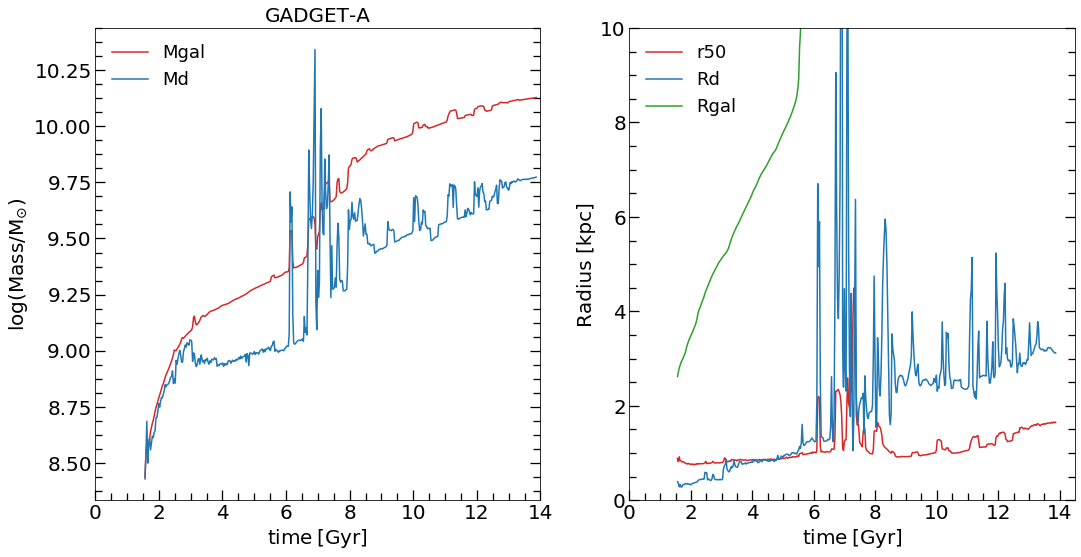

In [79]:
#-----grafico-----------
# import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))#, sharex=True, sharey=True)#, sharex=True,
#                        gridspec_kw = {'height_ratios':[2,1,2,1]})
fig.subplots_adjust(bottom=0.10, left =0.12, right = 0.97, top = 0.92)

ax[0].plot(time_M31gd, np.log10(Mgal_M31gd), '-', lw=1.5, color = 'tab:red', label='Mgal')
ax[0].plot(time_M31gd, np.log10(Md_M31gd),'-', lw=1.5, color = 'tab:blue',label='Md')
ax[0].set_xlim(0,14)
# ax.set_ylim(0.7,2.5)
ax[0].set_xticks([0,2,4,6,8,10,12,14])
ax[0].set_ylabel(r'log(Mass/$\rm{M_{\odot}}$)',fontsize=20)
ax[0].set_xlabel(r'$\mathrm{time\:[Gyr]}$',fontsize=20)
ax[0].minorticks_on()
ax[0].tick_params( labelsize=20)
ax[0].tick_params('both', length=7, width=1.3,which='minor', direction='in', right=True,top=False)
ax[0].tick_params('both', length=10, width=1.3,which='major', direction='in', right=True,top=False)
ax[0].legend(fontsize=18,frameon=False, loc=2)
ax[0].set_title('GADGET-A',fontsize=20)

ax[1].plot(time_M31gd, r50_M31gd, '-', lw=1.5, color = 'tab:red', label='r50')
ax[1].plot(time_M31gd, Rd_M31gd,'-', lw=1.5, color = 'tab:blue',label='Rd')
ax[1].plot(time_M31gd, rgal_M31gd,'-', lw=1.5, color = 'tab:green',label='Rgal')
ax[1].set_xticks([0,2,4,6,8,10,12,14])
ax[1].set_ylabel(r'Radius [kpc]',fontsize=20)
ax[1].set_xlabel(r'$\mathrm{time\:[Gyr]}$',fontsize=20)
ax[1].set_ylim(0,10)
ax[1].minorticks_on()
ax[1].tick_params( labelsize=20)
ax[1].tick_params('both', length=7, width=1.3,which='minor', direction='in', right=True,top=False)
ax[1].tick_params('both', length=10, width=1.3,which='major', direction='in', right=True,top=False)

ax[1].legend(fontsize=18,frameon=False, loc=2)
plt.show()

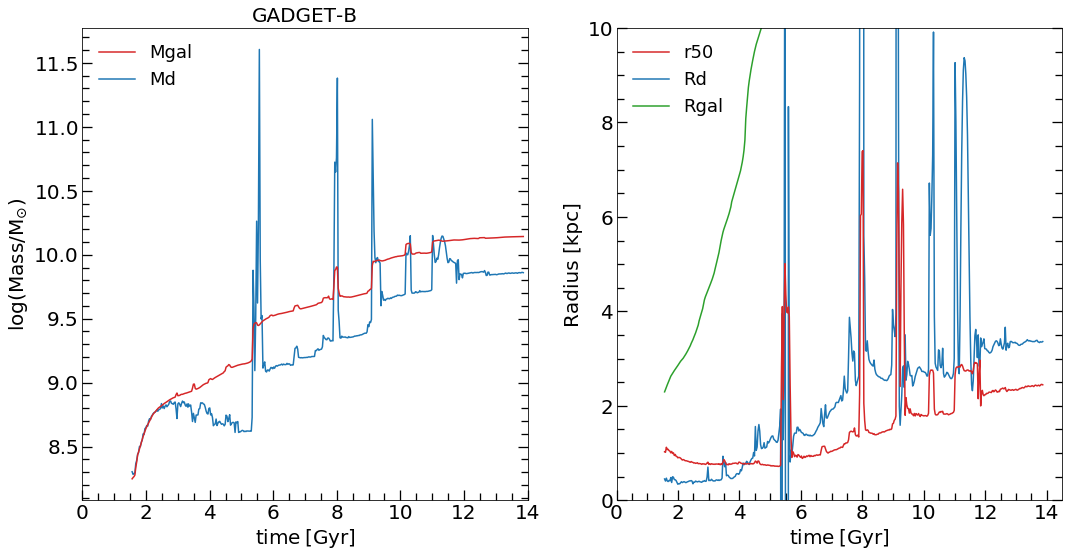

In [81]:
#-----grafico-----------
# import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))#, sharex=True, sharey=True)#, sharex=True,
#                        gridspec_kw = {'height_ratios':[2,1,2,1]})
fig.subplots_adjust(bottom=0.10, left =0.12, right = 0.97, top = 0.92)

ax[0].plot(time_MWgd, np.log10(Mgal_MWgd), '-', lw=1.5, color = 'tab:red', label='Mgal',zorder=25)
ax[0].plot(time_MWgd, np.log10(Md_MWgd),'-', lw=1.5, color = 'tab:blue',label='Md')
ax[0].set_xlim(0,14)
# ax.set_ylim(0.7,2.5)
ax[0].set_xticks([0,2,4,6,8,10,12,14])
ax[0].set_ylabel(r'log(Mass/$\rm{M_{\odot}}$)',fontsize=20)
ax[0].set_xlabel(r'$\mathrm{time\:[Gyr]}$',fontsize=20)
ax[0].minorticks_on()
ax[0].tick_params( labelsize=20)
ax[0].tick_params('both', length=7, width=1.3,which='minor', direction='in', right=True,top=False)
ax[0].tick_params('both', length=10, width=1.3,which='major', direction='in', right=True,top=False)
ax[0].legend(fontsize=18,frameon=False, loc=2)
ax[0].set_title('GADGET-B',fontsize=20)

ax[1].plot(time_MWgd, r50_MWgd, '-', lw=1.5, color = 'tab:red', label='r50',zorder=25)
ax[1].plot(time_MWgd, Rd_MWgd,'-', lw=1.5, color = 'tab:blue',label='Rd')
ax[1].plot(time_MWgd, rgal_MWgd,'-', lw=1.5, color = 'tab:green',label='Rgal')
ax[1].set_xticks([0,2,4,6,8,10,12,14])
ax[1].set_ylabel(r'Radius [kpc]',fontsize=20)
ax[1].set_xlabel(r'$\mathrm{time\:[Gyr]}$',fontsize=20)
ax[1].set_ylim(0,10)
ax[1].minorticks_on()
ax[1].tick_params( labelsize=20)
ax[1].tick_params('both', length=7, width=1.3,which='minor', direction='in', right=True,top=False)
ax[1].tick_params('both', length=10, width=1.3,which='major', direction='in', right=True,top=False)

ax[1].legend(fontsize=18,frameon=False, loc=2)
plt.show()

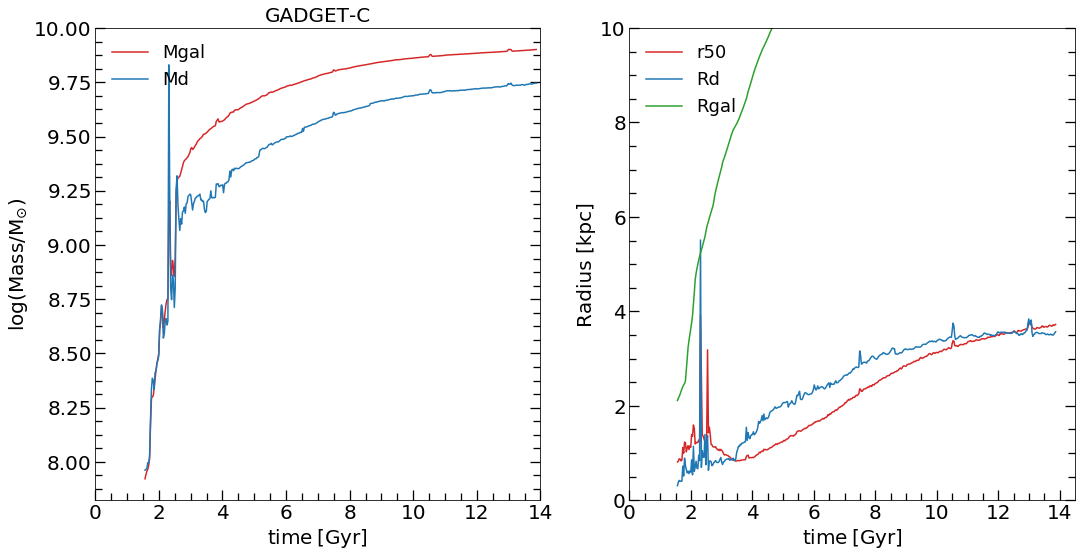

In [82]:
#-----grafico-----------
# import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))#, sharex=True, sharey=True)#, sharex=True,
#                        gridspec_kw = {'height_ratios':[2,1,2,1]})
fig.subplots_adjust(bottom=0.10, left =0.12, right = 0.97, top = 0.92)

ax[0].plot(time_M33gd, np.log10(Mgal_M33gd), '-', lw=1.5, color = 'tab:red', label='Mgal')
ax[0].plot(time_M33gd, np.log10(Md_M33gd),'-', lw=1.5, color = 'tab:blue',label='Md')
ax[0].set_xlim(0,14)
# ax.set_ylim(0.7,2.5)
ax[0].set_xticks([0,2,4,6,8,10,12,14])
ax[0].set_ylabel(r'log(Mass/$\rm{M_{\odot}}$)',fontsize=20)
ax[0].set_xlabel(r'$\mathrm{time\:[Gyr]}$',fontsize=20)
ax[0].minorticks_on()
ax[0].tick_params( labelsize=20)
ax[0].tick_params('both', length=7, width=1.3,which='minor', direction='in', right=True,top=False)
ax[0].tick_params('both', length=10, width=1.3,which='major', direction='in', right=True,top=False)
ax[0].legend(fontsize=18,frameon=False, loc=2)
ax[0].set_title('GADGET-C',fontsize=20)

ax[1].plot(time_M33gd, r50_M33gd, '-', lw=1.5, color = 'tab:red', label='r50')
ax[1].plot(time_M33gd, Rd_M33gd,'-', lw=1.5, color = 'tab:blue',label='Rd')
ax[1].plot(time_M33gd, rgal_M33gd,'-', lw=1.5, color = 'tab:green',label='Rgal')
ax[1].set_xticks([0,2,4,6,8,10,12,14])
ax[1].set_ylabel(r'Radius [kpc]',fontsize=20)
ax[1].set_xlabel(r'$\mathrm{time\:[Gyr]}$',fontsize=20)
ax[1].set_ylim(0,10)
ax[1].minorticks_on()
ax[1].tick_params( labelsize=20)
ax[1].tick_params('both', length=7, width=1.3,which='minor', direction='in', right=True,top=False)
ax[1].tick_params('both', length=10, width=1.3,which='major', direction='in', right=True,top=False)

ax[1].legend(fontsize=18,frameon=False, loc=2)
plt.show()

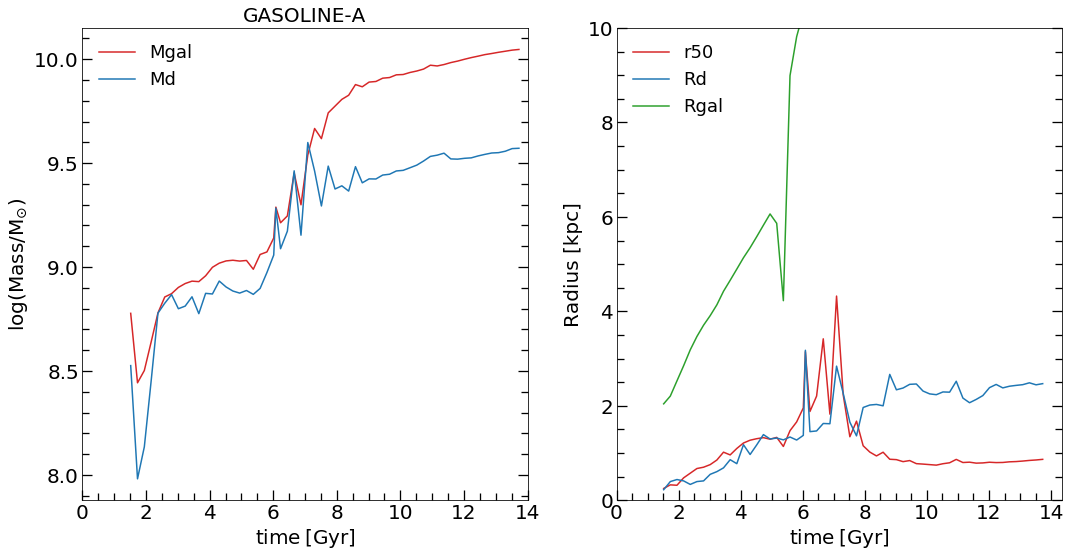

In [83]:
#-----grafico-----------
# import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))#, sharex=True, sharey=True)#, sharex=True,
#                        gridspec_kw = {'height_ratios':[2,1,2,1]})
fig.subplots_adjust(bottom=0.10, left =0.12, right = 0.97, top = 0.92)

ax[0].plot(time_M31gs, np.log10(Mgal_M31gs), '-', lw=1.5, color = 'tab:red', label='Mgal')
ax[0].plot(time_M31gs, np.log10(Md_M31gs),'-', lw=1.5, color = 'tab:blue',label='Md')
ax[0].set_xlim(0,14)
# ax.set_ylim(0.7,2.5)
ax[0].set_xticks([0,2,4,6,8,10,12,14])
ax[0].set_ylabel(r'log(Mass/$\rm{M_{\odot}}$)',fontsize=20)
ax[0].set_xlabel(r'$\mathrm{time\:[Gyr]}$',fontsize=20)
ax[0].minorticks_on()
ax[0].tick_params( labelsize=20)
ax[0].tick_params('both', length=7, width=1.3,which='minor', direction='in', right=True,top=False)
ax[0].tick_params('both', length=10, width=1.3,which='major', direction='in', right=True,top=False)
ax[0].legend(fontsize=18,frameon=False, loc=2)
ax[0].set_title('GASOLINE-A',fontsize=20)

ax[1].plot(time_M31gs, r50_M31gs, '-', lw=1.5, color = 'tab:red', label='r50')
ax[1].plot(time_M31gs, Rd_M31gs,'-', lw=1.5, color = 'tab:blue',label='Rd')
ax[1].plot(time_M31gs, rgal_M31gs,'-', lw=1.5, color = 'tab:green',label='Rgal')
ax[1].set_xticks([0,2,4,6,8,10,12,14])
ax[1].set_ylabel(r'Radius [kpc]',fontsize=20)
ax[1].set_xlabel(r'$\mathrm{time\:[Gyr]}$',fontsize=20)
ax[1].set_ylim(0,10)
ax[1].minorticks_on()
ax[1].tick_params( labelsize=20)
ax[1].tick_params('both', length=7, width=1.3,which='minor', direction='in', right=True,top=False)
ax[1].tick_params('both', length=10, width=1.3,which='major', direction='in', right=True,top=False)

ax[1].legend(fontsize=18,frameon=False, loc=2)
plt.show()

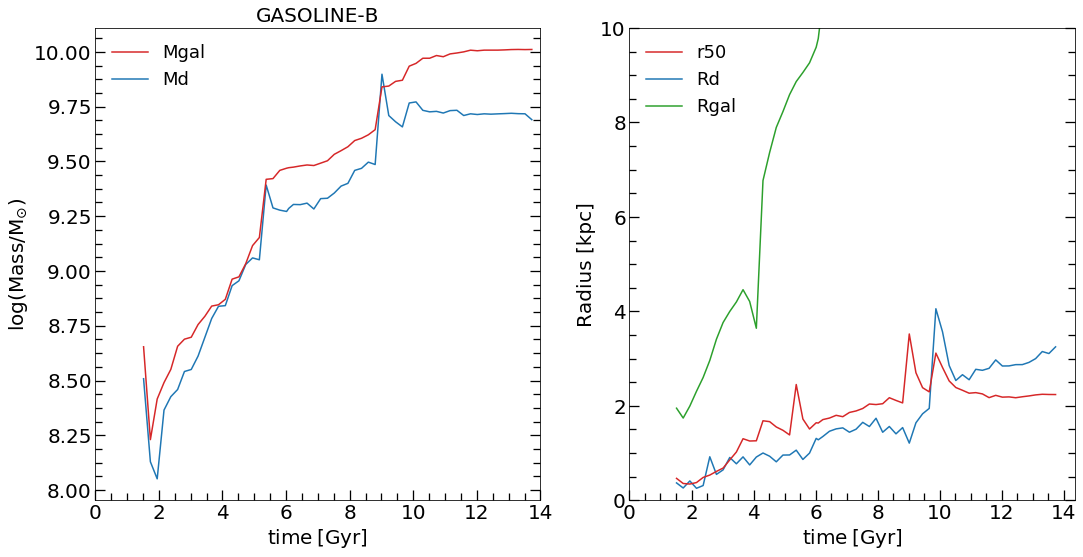

In [84]:
#-----grafico-----------
# import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))#, sharex=True, sharey=True)#, sharex=True,
#                        gridspec_kw = {'height_ratios':[2,1,2,1]})
fig.subplots_adjust(bottom=0.10, left =0.12, right = 0.97, top = 0.92)

ax[0].plot(time_MWgs, np.log10(Mgal_MWgs), '-', lw=1.5, color = 'tab:red', label='Mgal',zorder=25)
ax[0].plot(time_MWgs, np.log10(Md_MWgs),'-', lw=1.5, color = 'tab:blue',label='Md')
ax[0].set_xlim(0,14)
# ax.set_ylim(0.7,2.5)
ax[0].set_xticks([0,2,4,6,8,10,12,14])
ax[0].set_ylabel(r'log(Mass/$\rm{M_{\odot}}$)',fontsize=20)
ax[0].set_xlabel(r'$\mathrm{time\:[Gyr]}$',fontsize=20)
ax[0].minorticks_on()
ax[0].tick_params( labelsize=20)
ax[0].tick_params('both', length=7, width=1.3,which='minor', direction='in', right=True,top=False)
ax[0].tick_params('both', length=10, width=1.3,which='major', direction='in', right=True,top=False)
ax[0].legend(fontsize=18,frameon=False, loc=2)
ax[0].set_title('GASOLINE-B',fontsize=20)

ax[1].plot(time_MWgs, r50_MWgs, '-', lw=1.5, color = 'tab:red', label='r50',zorder=25)
ax[1].plot(time_MWgs, Rd_MWgs,'-', lw=1.5, color = 'tab:blue',label='Rd')
ax[1].plot(time_MWgs, rgal_MWgs,'-', lw=1.5, color = 'tab:green',label='Rgal')
ax[1].set_xticks([0,2,4,6,8,10,12,14])
ax[1].set_ylabel(r'Radius [kpc]',fontsize=20)
ax[1].set_xlabel(r'$\mathrm{time\:[Gyr]}$',fontsize=20)
ax[1].set_ylim(0,10)
ax[1].minorticks_on()
ax[1].tick_params( labelsize=20)
ax[1].tick_params('both', length=7, width=1.3,which='minor', direction='in', right=True,top=False)
ax[1].tick_params('both', length=10, width=1.3,which='major', direction='in', right=True,top=False)

ax[1].legend(fontsize=18,frameon=False, loc=2)
plt.show()

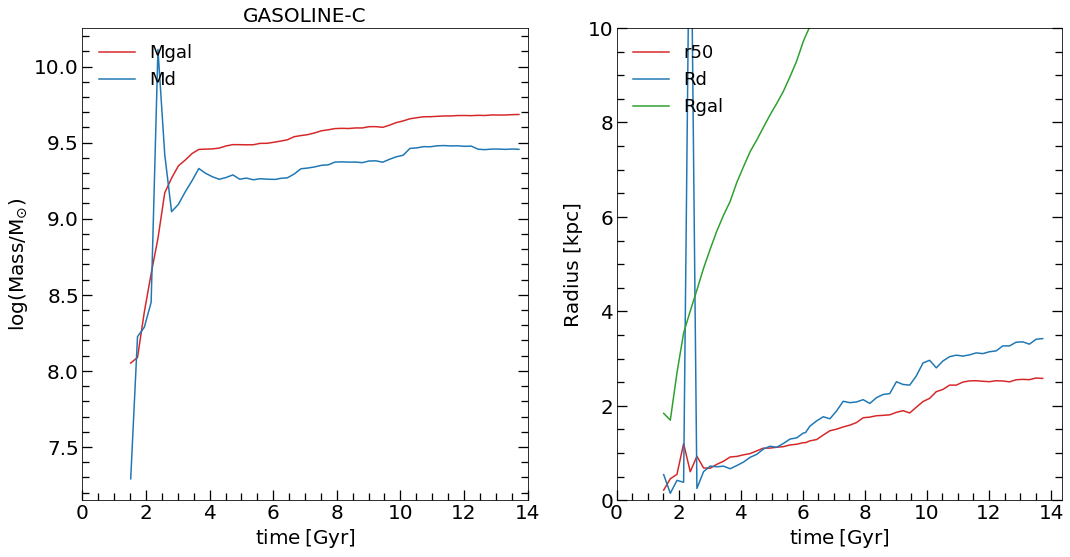

In [85]:
#-----grafico-----------
# import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))#, sharex=True, sharey=True)#, sharex=True,
#                        gridspec_kw = {'height_ratios':[2,1,2,1]})
fig.subplots_adjust(bottom=0.10, left =0.12, right = 0.97, top = 0.92)

ax[0].plot(time_M33gs, np.log10(Mgal_M33gs), '-', lw=1.5, color = 'tab:red', label='Mgal')
ax[0].plot(time_M33gs, np.log10(Md_M33gs),'-', lw=1.5, color = 'tab:blue',label='Md')
ax[0].set_xlim(0,14)
# ax.set_ylim(0.7,2.5)
ax[0].set_xticks([0,2,4,6,8,10,12,14])
ax[0].set_ylabel(r'log(Mass/$\rm{M_{\odot}}$)',fontsize=20)
ax[0].set_xlabel(r'$\mathrm{time\:[Gyr]}$',fontsize=20)
ax[0].minorticks_on()
ax[0].tick_params( labelsize=20)
ax[0].tick_params('both', length=7, width=1.3,which='minor', direction='in', right=True,top=False)
ax[0].tick_params('both', length=10, width=1.3,which='major', direction='in', right=True,top=False)
ax[0].legend(fontsize=18,frameon=False, loc=2)
ax[0].set_title('GASOLINE-C',fontsize=20)

ax[1].plot(time_M33gs, r50_M33gs, '-', lw=1.5, color = 'tab:red', label='r50')
ax[1].plot(time_M33gs, Rd_M33gs,'-', lw=1.5, color = 'tab:blue',label='Rd')
ax[1].plot(time_M33gs, rgal_M33gs,'-', lw=1.5, color = 'tab:green',label='Rgal')
ax[1].set_xticks([0,2,4,6,8,10,12,14])
ax[1].set_ylabel(r'Radius [kpc]',fontsize=20)
ax[1].set_xlabel(r'$\mathrm{time\:[Gyr]}$',fontsize=20)
ax[1].set_ylim(0,10)
ax[1].minorticks_on()
ax[1].tick_params( labelsize=20)
ax[1].tick_params('both', length=7, width=1.3,which='minor', direction='in', right=True,top=False)
ax[1].tick_params('both', length=10, width=1.3,which='major', direction='in', right=True,top=False)

ax[1].legend(fontsize=18,frameon=False, loc=2)
plt.show()

In [45]:
import numpy as np
# G = 4.299e-6 masas solares, kpc, km/s

def fdisk(velocity, mass, radius, G = 4.299e-6):
    
    fdisk = velocity / np.sqrt(G*mass/radius)
    
    return fdisk

### M31 gadget

In [46]:
fdisk_M31gd  = fdisk(V50_M31gd, Mgal_M31gd, r50_M31gd)
fdisk0_M31gd = fdisk(Vmax_M31gd, Mgal_M31gd, r50_M31gd)
fdisk1_M31gd = fdisk(Vmax_M31gd, Md_M31gd, r50_M31gd)
fdisk2_M31gd = fdisk(Vmax_M31gd, Md_M31gd, Rd_M31gd)

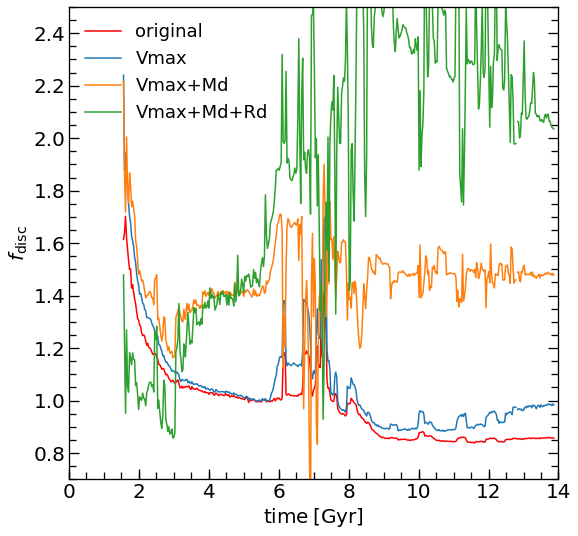

In [47]:
#-----grafico-----------
from matplotlib.ticker import MultipleLocator
import matplotlib.ticker as ticker
from matplotlib.ticker import StrMethodFormatter, NullFormatter

import matplotlib.pyplot as plt
import time_conversion as tiempo
from matplotlib.ticker import AutoMinorLocator

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))#, sharex=True, sharey=True)#, sharex=True,
#                        gridspec_kw = {'height_ratios':[2,1,2,1]})
fig.subplots_adjust(bottom=0.10, left =0.12, right = 0.97, top = 0.92)

ax.plot(time_M31gd, fdisk_M31gd, '-', lw=1.5, color = 'r', label='original')
ax.plot(time_M31gd, fdisk0_M31gd,'-', lw=1.5, color = 'tab:blue',label='Vmax')
ax.plot(time_M31gd, fdisk1_M31gd,'-', lw=1.5, color = 'tab:orange',label='Vmax+Md')
ax.plot(time_M31gd, fdisk2_M31gd,'-', lw=1.5, color = 'tab:green',label='Vmax+Md+Rd')
# ax.plot(time_M31gd, fdisk3_M31gd,'-', lw=1.5, color = 'tab:purple',label='Vmax+2r50+Mdisk_star+gas')

ax.set_xlim(0,14)
ax.set_ylim(0.7,2.5)
# ax.set_yscale('log')
ax.set_xticks([0,2,4,6,8,10,12,14])
# ax.set_yticks(np.arange(1,5,1))
# ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_ylabel(r'$f_{\mathrm{disc}}$',fontsize=20)
ax.set_xlabel(r'$\mathrm{time\:[Gyr]}$',fontsize=20)

ax.spines['right'].set_linewidth(1.3)
ax.spines['left'].set_linewidth(1.3)
ax.spines['top'].set_linewidth(1.3)
ax.spines['bottom'].set_linewidth(1.3)

ax.minorticks_on()
ax.tick_params( labelsize=20)
ax.tick_params('both', length=7, width=1.3,which='minor', direction='in', right=True,top=False)
ax.tick_params('both', length=10, width=1.3,which='major', direction='in', right=True,top=False)
ax.xaxis.set_minor_locator(MultipleLocator(1/2.))

ax.legend(fontsize=18,frameon=False, loc=2)
plt.show()

### M31 gasoline

In [48]:
fdisk_M31gs  = fdisk(V50_M31gs,  Mgal_M31gs, r50_M31gs)
fdisk0_M31gs = fdisk(Vmax_M31gs, Mgal_M31gs, r50_M31gs)
fdisk1_M31gs = fdisk(Vmax_M31gs, Md_M31gs,   r50_M31gs)
fdisk2_M31gs = fdisk(Vmax_M31gs, Md_M31gs,   Rd_M31gs)

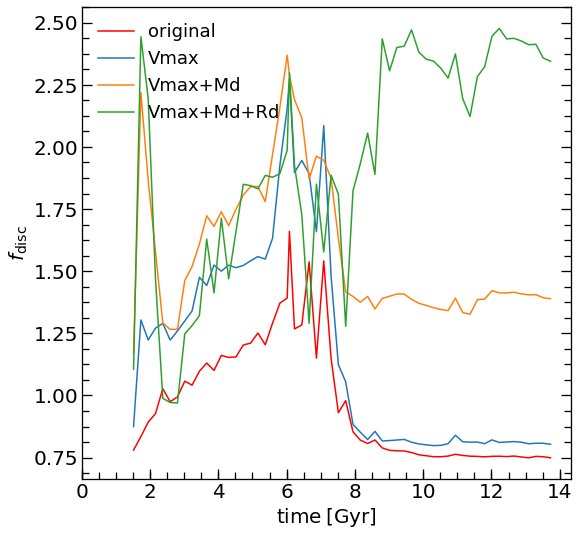

In [49]:
#-----grafico-----------
from matplotlib.ticker import MultipleLocator
import matplotlib.ticker as ticker
from matplotlib.ticker import StrMethodFormatter, NullFormatter

import matplotlib.pyplot as plt
import time_conversion as tiempo
from matplotlib.ticker import AutoMinorLocator

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))#, sharex=True, sharey=True)#, sharex=True,
#                        gridspec_kw = {'height_ratios':[2,1,2,1]})
fig.subplots_adjust(bottom=0.10, left =0.12, right = 0.97, top = 0.92)

ax.plot(time_M31gs, fdisk_M31gs, '-', lw=1.5, color = 'r', label='original')
ax.plot(time_M31gs, fdisk0_M31gs,'-', lw=1.5, color = 'tab:blue',label='Vmax')
ax.plot(time_M31gs, fdisk1_M31gs,'-', lw=1.5, color = 'tab:orange',label='Vmax+Md')
ax.plot(time_M31gs, fdisk2_M31gs,'-', lw=1.5, color = 'tab:green',label='Vmax+Md+Rd')
# ax.plot(time_M31gd, fdisk3_M31gd,'-', lw=1.5, color = 'tab:purple',label='Vmax+2r50+Mdisk_star+gas')

# ax.set_xlim(0,14)
# ax.set_ylim(0.7,2.5)
# ax.set_yscale('log')
ax.set_xticks([0,2,4,6,8,10,12,14])
# ax.set_yticks(np.arange(1,5,1))
# ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_ylabel(r'$f_{\mathrm{disc}}$',fontsize=20)
ax.set_xlabel(r'$\mathrm{time\:[Gyr]}$',fontsize=20)

ax.spines['right'].set_linewidth(1.3)
ax.spines['left'].set_linewidth(1.3)
ax.spines['top'].set_linewidth(1.3)
ax.spines['bottom'].set_linewidth(1.3)

ax.minorticks_on()
ax.tick_params( labelsize=20)
ax.tick_params('both', length=7, width=1.3,which='minor', direction='in', right=True,top=False)
ax.tick_params('both', length=10, width=1.3,which='major', direction='in', right=True,top=False)
ax.xaxis.set_minor_locator(MultipleLocator(1/2.))

ax.legend(fontsize=18,frameon=False, loc=2)
plt.show()

### MW gadget

In [50]:
fdisk_MWgd  = fdisk(V50_MWgd,  Mgal_MWgd, r50_MWgd)
fdisk0_MWgd = fdisk(Vmax_MWgd, Mgal_MWgd, r50_MWgd)
fdisk1_MWgd = fdisk(Vmax_MWgd, Md_MWgd,   r50_MWgd)
fdisk2_MWgd = fdisk(Vmax_MWgd, Md_MWgd,   Rd_MWgd)

/home/ornela/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  


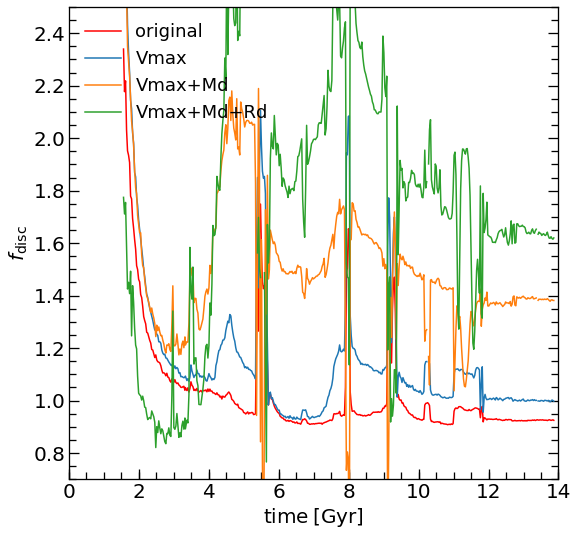

In [51]:
#-----grafico-----------
from matplotlib.ticker import MultipleLocator
import matplotlib.ticker as ticker
from matplotlib.ticker import StrMethodFormatter, NullFormatter

import matplotlib.pyplot as plt
import time_conversion as tiempo
from matplotlib.ticker import AutoMinorLocator

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))#, sharex=True, sharey=True)#, sharex=True,
#                        gridspec_kw = {'height_ratios':[2,1,2,1]})
fig.subplots_adjust(bottom=0.10, left =0.12, right = 0.97, top = 0.92)

ax.plot(time_MWgd, fdisk_MWgd, '-', lw=1.5, color = 'r', label='original')
ax.plot(time_MWgd, fdisk0_MWgd,'-', lw=1.5, color = 'tab:blue',label='Vmax')
ax.plot(time_MWgd, fdisk1_MWgd,'-', lw=1.5, color = 'tab:orange',label='Vmax+Md')
ax.plot(time_MWgd, fdisk2_MWgd,'-', lw=1.5, color = 'tab:green',label='Vmax+Md+Rd')
# ax.plot(time_M31gd, fdisk3_M31gd,'-', lw=1.5, color = 'tab:purple',label='Vmax+2r50+Mdisk_star+gas')

ax.set_xlim(0,14)
ax.set_ylim(0.7,2.5)
# ax.set_yscale('log')
ax.set_xticks([0,2,4,6,8,10,12,14])
# ax.set_yticks(np.arange(1,5,1))
# ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_ylabel(r'$f_{\mathrm{disc}}$',fontsize=20)
ax.set_xlabel(r'$\mathrm{time\:[Gyr]}$',fontsize=20)

ax.spines['right'].set_linewidth(1.3)
ax.spines['left'].set_linewidth(1.3)
ax.spines['top'].set_linewidth(1.3)
ax.spines['bottom'].set_linewidth(1.3)

ax.minorticks_on()
ax.tick_params( labelsize=20)
ax.tick_params('both', length=7, width=1.3,which='minor', direction='in', right=True,top=False)
ax.tick_params('both', length=10, width=1.3,which='major', direction='in', right=True,top=False)
ax.xaxis.set_minor_locator(MultipleLocator(1/2.))

ax.legend(fontsize=18,frameon=False, loc=2)
plt.show()

### MW gasoline

In [52]:
fdisk_MWgs  = fdisk(V50_MWgs,  Mgal_MWgs, r50_MWgs)
fdisk0_MWgs = fdisk(Vmax_MWgs, Mgal_MWgs, r50_MWgs)
fdisk1_MWgs = fdisk(Vmax_MWgs, Md_MWgs,   r50_MWgs)
fdisk2_MWgs = fdisk(Vmax_MWgs, Md_MWgs,   Rd_MWgs)

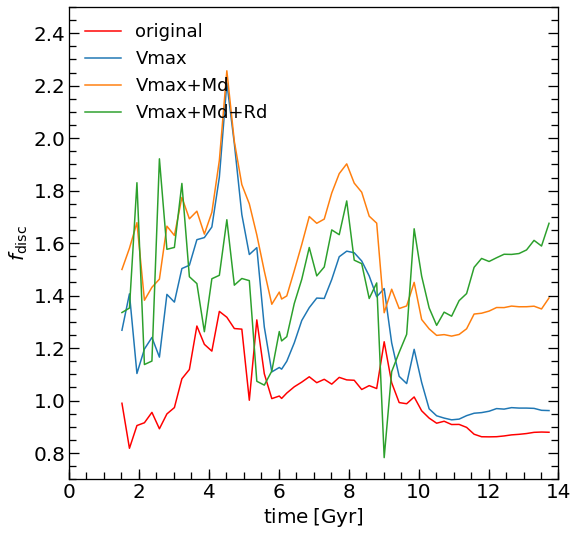

In [53]:
#-----grafico-----------
from matplotlib.ticker import MultipleLocator
import matplotlib.ticker as ticker
from matplotlib.ticker import StrMethodFormatter, NullFormatter

import matplotlib.pyplot as plt
import time_conversion as tiempo
from matplotlib.ticker import AutoMinorLocator

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))#, sharex=True, sharey=True)#, sharex=True,
#                        gridspec_kw = {'height_ratios':[2,1,2,1]})
fig.subplots_adjust(bottom=0.10, left =0.12, right = 0.97, top = 0.92)

ax.plot(time_MWgs, fdisk_MWgs, '-', lw=1.5, color = 'r', label='original')
ax.plot(time_MWgs, fdisk0_MWgs,'-', lw=1.5, color = 'tab:blue',label='Vmax')
ax.plot(time_MWgs, fdisk1_MWgs,'-', lw=1.5, color = 'tab:orange',label='Vmax+Md')
ax.plot(time_MWgs, fdisk2_MWgs,'-', lw=1.5, color = 'tab:green',label='Vmax+Md+Rd')
# ax.plot(time_M31gd, fdisk3_M31gd,'-', lw=1.5, color = 'tab:purple',label='Vmax+2r50+Mdisk_star+gas')

ax.set_xlim(0,14)
ax.set_ylim(0.7,2.5)
# ax.set_yscale('log')
ax.set_xticks([0,2,4,6,8,10,12,14])
# ax.set_yticks(np.arange(1,5,1))
# ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_ylabel(r'$f_{\mathrm{disc}}$',fontsize=20)
ax.set_xlabel(r'$\mathrm{time\:[Gyr]}$',fontsize=20)

ax.spines['right'].set_linewidth(1.3)
ax.spines['left'].set_linewidth(1.3)
ax.spines['top'].set_linewidth(1.3)
ax.spines['bottom'].set_linewidth(1.3)

ax.minorticks_on()
ax.tick_params( labelsize=20)
ax.tick_params('both', length=7, width=1.3,which='minor', direction='in', right=True,top=False)
ax.tick_params('both', length=10, width=1.3,which='major', direction='in', right=True,top=False)
ax.xaxis.set_minor_locator(MultipleLocator(1/2.))

ax.legend(fontsize=18,frameon=False, loc=2)
plt.show()

### M33 gadget

In [54]:
fdisk_M33gd  = fdisk(V50_M33gd,  Mgal_M33gd, r50_M33gd)
fdisk0_M33gd = fdisk(Vmax_M33gd, Mgal_M33gd, r50_M33gd)
fdisk1_M33gd = fdisk(Vmax_M33gd, Md_M33gd,   r50_M33gd)
fdisk2_M33gd = fdisk(Vmax_M33gd, Md_M33gd,   Rd_M33gd)

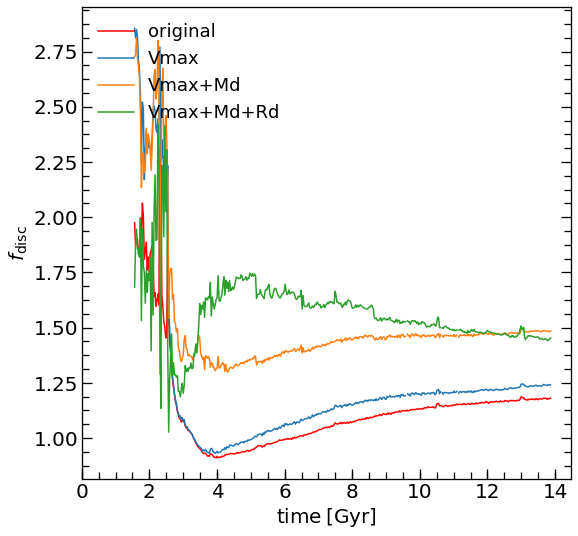

In [55]:
#-----grafico-----------
from matplotlib.ticker import MultipleLocator
import matplotlib.ticker as ticker
from matplotlib.ticker import StrMethodFormatter, NullFormatter

import matplotlib.pyplot as plt
import time_conversion as tiempo
from matplotlib.ticker import AutoMinorLocator

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))#, sharex=True, sharey=True)#, sharex=True,
#                        gridspec_kw = {'height_ratios':[2,1,2,1]})
fig.subplots_adjust(bottom=0.10, left =0.12, right = 0.97, top = 0.92)

ax.plot(time_M33gd, fdisk_M33gd, '-', lw=1.5, color = 'r', label='original')
ax.plot(time_M33gd, fdisk0_M33gd,'-', lw=1.5, color = 'tab:blue',label='Vmax')
ax.plot(time_M33gd, fdisk1_M33gd,'-', lw=1.5, color = 'tab:orange',label='Vmax+Md')
ax.plot(time_M33gd, fdisk2_M33gd,'-', lw=1.5, color = 'tab:green',label='Vmax+Md+Rd')
# ax.plot(time_M31gd, fdisk3_M31gd,'-', lw=1.5, color = 'tab:purple',label='Vmax+2r50+Mdisk_star+gas')

# ax.set_xlim(0,14)
# ax.set_ylim(0.7,2.5)
# ax.set_yscale('log')
ax.set_xticks([0,2,4,6,8,10,12,14])
# ax.set_yticks(np.arange(1,5,1))
# ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_ylabel(r'$f_{\mathrm{disc}}$',fontsize=20)
ax.set_xlabel(r'$\mathrm{time\:[Gyr]}$',fontsize=20)

ax.spines['right'].set_linewidth(1.3)
ax.spines['left'].set_linewidth(1.3)
ax.spines['top'].set_linewidth(1.3)
ax.spines['bottom'].set_linewidth(1.3)

ax.minorticks_on()
ax.tick_params( labelsize=20)
ax.tick_params('both', length=7, width=1.3,which='minor', direction='in', right=True,top=False)
ax.tick_params('both', length=10, width=1.3,which='major', direction='in', right=True,top=False)
ax.xaxis.set_minor_locator(MultipleLocator(1/2.))

ax.legend(fontsize=18,frameon=False, loc=2)
plt.show()

### M33 gasoline

In [56]:
fdisk_M33gs  = fdisk(V50_M33gs,  Mgal_M33gs, r50_M33gs)
fdisk0_M33gs = fdisk(Vmax_M33gs, Mgal_M33gs, r50_M33gs)
fdisk1_M33gs = fdisk(Vmax_M33gs, Md_M33gs,   r50_M33gs)
fdisk2_M33gs = fdisk(Vmax_M33gs, Md_M33gs,   Rd_M33gs)

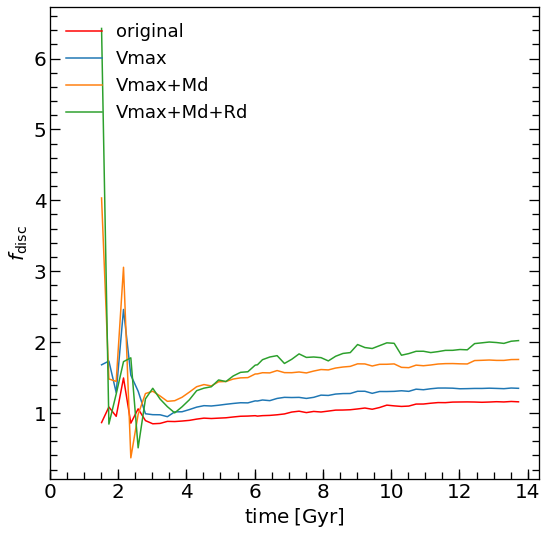

In [57]:
#-----grafico-----------
from matplotlib.ticker import MultipleLocator
import matplotlib.ticker as ticker
from matplotlib.ticker import StrMethodFormatter, NullFormatter

import matplotlib.pyplot as plt
import time_conversion as tiempo
from matplotlib.ticker import AutoMinorLocator

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))#, sharex=True, sharey=True)#, sharex=True,
#                        gridspec_kw = {'height_ratios':[2,1,2,1]})
fig.subplots_adjust(bottom=0.10, left =0.12, right = 0.97, top = 0.92)

ax.plot(time_M33gs, fdisk_M33gs, '-', lw=1.5, color = 'r', label='original')
ax.plot(time_M33gs, fdisk0_M33gs,'-', lw=1.5, color = 'tab:blue',label='Vmax')
ax.plot(time_M33gs, fdisk1_M33gs,'-', lw=1.5, color = 'tab:orange',label='Vmax+Md')
ax.plot(time_M33gs, fdisk2_M33gs,'-', lw=1.5, color = 'tab:green',label='Vmax+Md+Rd')
# ax.plot(time_M31gd, fdisk3_M31gd,'-', lw=1.5, color = 'tab:purple',label='Vmax+2r50+Mdisk_star+gas')

# ax.set_xlim(0,14)
# ax.set_ylim(0.7,2.5)
# ax.set_yscale('log')
ax.set_xticks([0,2,4,6,8,10,12,14])
# ax.set_yticks(np.arange(1,5,1))
# ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_ylabel(r'$f_{\mathrm{disc}}$',fontsize=20)
ax.set_xlabel(r'$\mathrm{time\:[Gyr]}$',fontsize=20)

ax.spines['right'].set_linewidth(1.3)
ax.spines['left'].set_linewidth(1.3)
ax.spines['top'].set_linewidth(1.3)
ax.spines['bottom'].set_linewidth(1.3)

ax.minorticks_on()
ax.tick_params( labelsize=20)
ax.tick_params('both', length=7, width=1.3,which='minor', direction='in', right=True,top=False)
ax.tick_params('both', length=10, width=1.3,which='major', direction='in', right=True,top=False)
ax.xaxis.set_minor_locator(MultipleLocator(1/2.))

ax.legend(fontsize=18,frameon=False, loc=2)
plt.show()